In [1]:
import pandas as pd
import statsmodels.api as sm

# Завантажуємо вбудований макроекономічний датасет
df = sm.datasets.macrodata.load_pandas().data

# Функція для створення дати з року та кварталу
def create_date(row):
    return pd.Timestamp(year=int(row['year']), month=int(row['quarter'] * 3 - 2), day=1)

# Застосовуємо функцію для створення нового стовпця з датою
df['date'] = df.apply(create_date, axis=1)

# Вибираємо відповідні стовпці для аналізу
df_selected = df[['date', 'cpi', 'm1', 'realinv', 'unemp']]

# Виводимо перші кілька рядків вибраного датафрейму
print(df_selected.head())

        date    cpi     m1  realinv  unemp
0 1959-01-01  28.98  139.7  286.898    5.8
1 1959-04-01  29.15  141.7  310.859    5.1
2 1959-07-01  29.35  140.5  289.226    5.3
3 1959-10-01  29.37  140.0  299.356    5.6
4 1960-01-01  29.54  139.6  331.722    5.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from optimizers import GDOptimizer
from model import NN
from layers import DenseLayer
from activations import ReLU
from losses import MSE
np.random.seed(42) 

# Перетворюємо дані в масиви
# X = df_selected[['m1', 'realinv', 'unemp']].values  # Вхідні змінні
# y = df_selected['cpi'].values  # Цільова змінна
year = df.drop_duplicates("year")

X = year[['m1', 'realinv', 'unemp']].values  # Вхідні змінні
y = year['cpi'].values  # Цільова змінна

Training on window 1 (0-20)


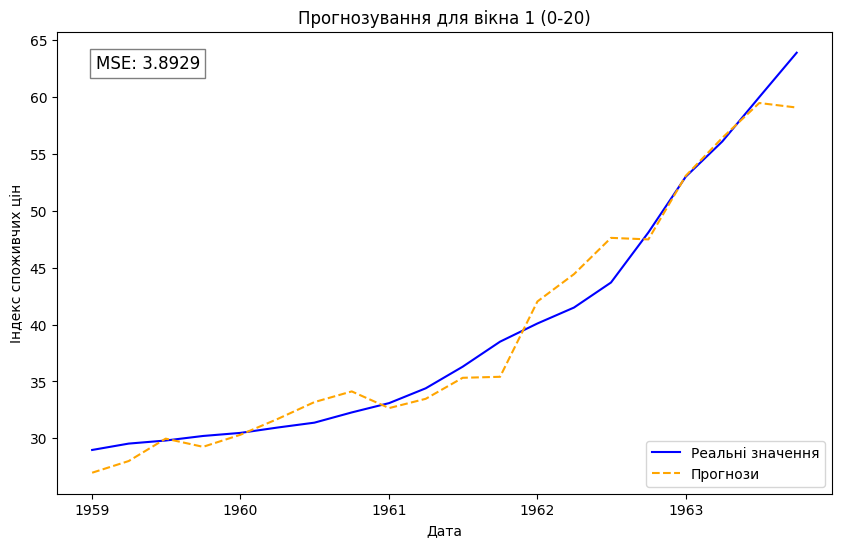

Training on window 2 (1-21)


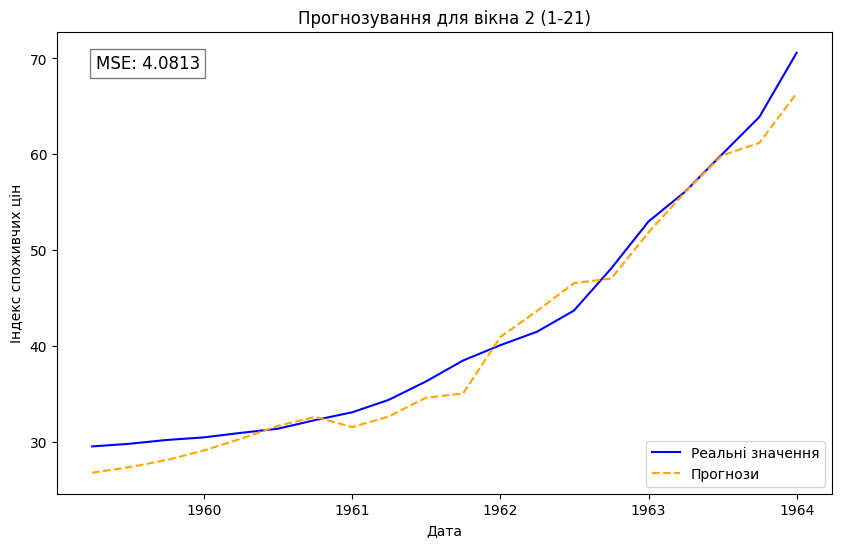

Training on window 3 (2-22)


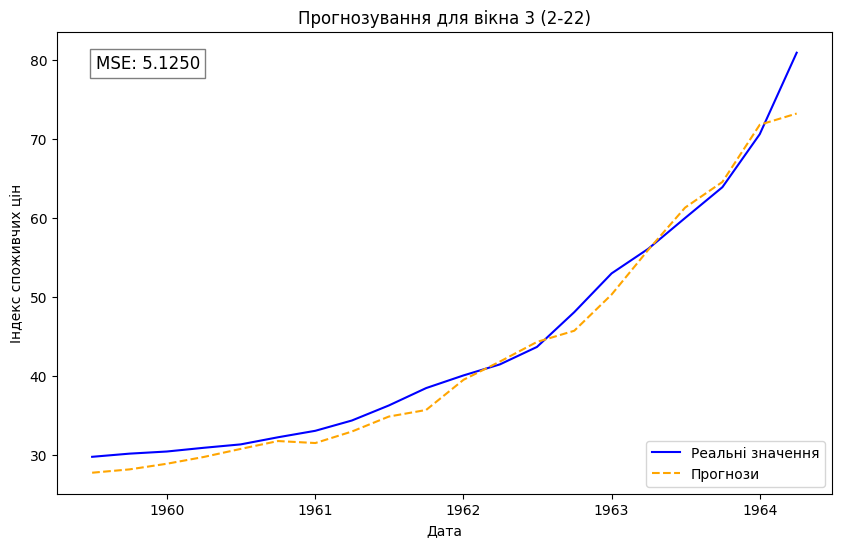

Training on window 4 (3-23)


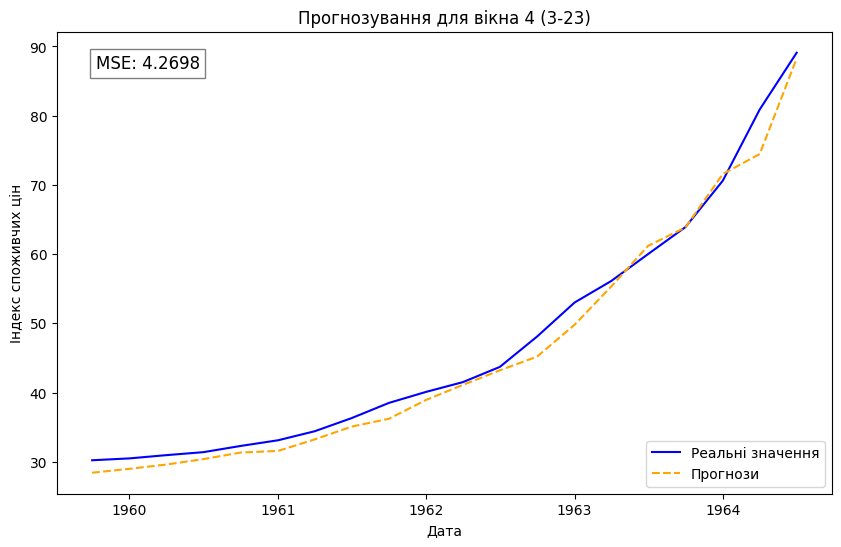

In [5]:
from sklearn.preprocessing import StandardScaler

# Нормалізуємо дані
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def sliding_window_training(X, y, window_size=12, num_windows=10):
    n_samples = X.shape[0]
    model = NN(X.shape[1])
    model.add_layer(DenseLayer(8, ReLU())) 
    model.add_layer(DenseLayer(1, ReLU()))  # Другий шар

    optimizer = GDOptimizer(eta=0.1)

    for window in range(num_windows):  # Цикл для всіх вікон
        start_index = window
        end_index = start_index + window_size
        
        if end_index > n_samples:
            break  # Вихід, якщо виходимо за межі даних
        
        print(f"Training on window {window + 1} ({start_index}-{end_index})")
        
        X_window = X_scaled[start_index:end_index]  # Використовуємо нормалізовані дані
        y_window = y[start_index:end_index].reshape(-1, 1)

        # Навчання мережі на поточному вікні
        model.fit(X_window, y_window, epochs=1000, optimizer=optimizer, loss_fn=MSE)

        # Прогнозування на основі навченої моделі
        predictions = model.forward(X_window)

        # Розрахунок DELTA та DELTA^2
        delta = predictions.flatten() - y_window.flatten()
        delta_squared = delta ** 2
        
        # Підготовка даних для таблиці
        results_df = pd.DataFrame({
            'Point': np.arange(window_size)[::-1],
            'IPC RO': y_window.flatten(),
            'IPC PO': predictions.flatten(),
            'DELTA': delta,
            'DELTA^2': delta_squared
        })
        
        # Обчислення TOTAL та MSE
        total_delta = delta.sum()
        total_delta_squared = delta_squared.sum()
        mse = np.mean(delta_squared)

        # Додавання підсумків до таблиці
        results_df.loc[len(results_df)] = ['TOTAL', '', total_delta, '', total_delta_squared]
        results_df.loc[len(results_df)] = ['MSE', '', '', '', mse]

        # Збереження результатів у Excel
        results_df.to_excel(f'sliding_window_results_window_{window + 1}.xlsx', index=False)

        # Ваш код для обробки та візуалізації
        # Візуалізація
        plt.figure(figsize=(10, 6))
        plt.plot(df_selected['date'][start_index:end_index], y_window, label='Реальні значення', color='blue')
        plt.plot(df_selected['date'][start_index:end_index], predictions, label='Прогнози', linestyle='--', color='orange')
        plt.xlabel('Дата')
        plt.ylabel('Індекс споживчих цін')
        plt.title(f'Прогнозування для вікна {window + 1} ({start_index}-{end_index})')
        plt.legend()
        # Додаємо MSE на графік
        plt.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.savefig(f'window_{window + 1}_forecast.png')  # Зберігаємо графік
        plt.show()

# Викликаємо функцію
sliding_window_training(X, y, window_size=20, num_windows=4)
